In [1]:
import numpy as np
import naima
import astropy.units as u
from astropy.io import ascii
from naima.models import Synchrotron, InverseCompton, Bremsstrahlung, ExponentialCutoffPowerLaw
import matplotlib as mpl
import matplotlib.pyplot as plt

#Full example can be found at 
#https://naima.readthedocs.io/en/latest/examples.html#fitting-a-minimal-radiative-model
#copied here for convenience.

#see also the examples here: https://github.com/zblz/naima/tree/master/examples

In [2]:
#read in data. See https://naima.readthedocs.io/en/latest/dataformat.html#dataformat

data = ascii.read("RXJ1713_HESS_2007.dat")

print(data)


energy energy_edge_lo energy_edge_hi       flux         flux_error    ul
 TeV        TeV            TeV       1 / (cm2 s TeV) 1 / (cm2 s TeV)    
------ -------------- -------------- --------------- --------------- ---
  0.33            0.3           0.37        2.29e-10         3.2e-11   0
   0.4           0.37           0.44        1.25e-10         1.6e-11   0
  0.49           0.44           0.54        9.46e-11           9e-12   0
  0.59           0.54           0.65        6.06e-11         5.2e-12   0
  0.71           0.65           0.79        4.37e-11         3.1e-12   0
  0.86           0.79           0.95        2.15e-11         1.8e-12   0
  1.04           0.95           1.15        1.82e-11         1.1e-12   0
  1.26           1.15           1.39        1.17e-11           7e-13   0
  1.53           1.39           1.69        8.87e-12           5e-13   0
  1.85           1.69           2.04        5.63e-12         3.3e-13   0
   ...            ...            ...             ..

In [3]:
#model definition
#pars is a list/array of parameters to be fitted.
#the 'data' parameter will contain the energies of the data points,
#which are the energies at which the model will be evaluated.
#return value is the flux (dN/dE/dA/dt) at the energies at which we have data points.

def ElectronIC(pars, data):
    """
    Define particle distribution model, radiative model, and return model flux
    at data energy values
    """

    ECPL = ExponentialCutoffPowerLaw(
        pars[0] / u.eV, 10.0 * u.TeV, pars[1], 10 ** pars[2] * u.TeV
    )
    IC = InverseCompton(ECPL, seed_photon_fields=["CMB"])

    return IC.flux(data, distance=1.0 * u.kpc)

#Priors for the bayesian sampler.
#In this case, set un-informative priors.
#We could add limits or even gaussian priors for the other parameters here.
def lnprior(pars):
    # Limit amplitude to positive domain
    logprob = naima.uniform_prior(pars[0], 0.0, np.inf)
    return logprob


In [4]:
#initial parameters, sampling, and saving of output.
#This will take a few minutes to run.
#several output files will be created.


## Set initial parameters and labels
#parameters here: 
#electron normalization in eV**-1, electron index, electron cutoff energy in TeV.
p0 = np.array((1e30, 3.0, np.log10(30))) 
labels = ["norm", "index", "log10(cutoff)"]

## Run sampler
sampler, pos = naima.run_sampler(
        data_table=data,
        p0=p0,
        labels=labels,
        model=ElectronIC,
        prior=lnprior,
        nwalkers=32,
        nburn=100,
        nrun=20,
        threads=4,
        prefit=True,
        interactive=False,
)
#Try running with more walkers or increasing the number of runs.

## Save run results
out_root = "RXJ1713_IC_minimal"
naima.save_run(out_root, sampler)

## Save diagnostic plots and results table
naima.save_diagnostic_plots(out_root, sampler, sed=True)
naima.save_results_table(out_root, sampler)

INFO: Finding Maximum Likelihood parameters through Nelder-Mead fitting... [naima.core]
INFO:    Initial parameters: [4.74159481e+32 3.00000000e+00 1.47712125e+00] [naima.core]
INFO:    Initial lnprob(p0): -177.635 [naima.core]
INFO:    New ML parameters : [2.60447918e+32 2.61876368e+00 1.71023212e+00] [naima.core]
INFO:    Maximum lnprob(p0): -17.902 [naima.core]
Burning in the 32 walkers with 100 steps...

Progress of the run: 0 percent (0 of 100 steps)
                           -----norm------ -----index----- -log10(cutoff)-
  Last ensemble median :    2.61e+32          2.62            1.71      
  Last ensemble std    :    1.54e+30          0.014          0.0119     
  Last ensemble lnprob :  avg: -18.342, max: -17.906

Progress of the run: 5 percent (5 of 100 steps)
                           -----norm------ -----index----- -log10(cutoff)-
  Last ensemble median :     2.6e+32          2.62            1.71      
  Last ensemble std    :    4.11e+30         0.0353          0.0238  


Progress of the run: 25 percent (5 of 20 steps)
                           -----norm------ -----index----- -log10(cutoff)-
  Last ensemble median :    2.63e+32          2.64            1.74      
  Last ensemble std    :    8.44e+30          0.144           0.105     
  Last ensemble lnprob :  avg: -19.358, max: -17.966

Progress of the run: 30 percent (6 of 20 steps)
                           -----norm------ -----index----- -log10(cutoff)-
  Last ensemble median :    2.64e+32          2.65            1.75      
  Last ensemble std    :    8.69e+30          0.144            0.1      
  Last ensemble lnprob :  avg: -19.328, max: -18.114

Progress of the run: 35 percent (7 of 20 steps)
                           -----norm------ -----index----- -log10(cutoff)-
  Last ensemble median :    2.62e+32          2.63            1.74      
  Last ensemble std    :      9e+30           0.131          0.0945     
  Last ensemble lnprob :  avg: -19.173, max: -18.080

Progress of the run: 40 percen

/opt/anaconda/envs/fermi/lib/python3.7/site-packages/naima/analysis.py:160: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  f.clf()


label,median,unc_lo,unc_hi
bytes72,float64,float64,float64
norm,2.6186329241490554e+32,1.1066844579972474e+31,9.168749966622757e+30
index,2.6383865459645985,0.16860512700292052,0.12119918391575712
log10(cutoff),1.728393758594265,0.116917202491299,0.10307666632506085
cutoff,53.505010239135615,12.628241679637107,14.332582240443642


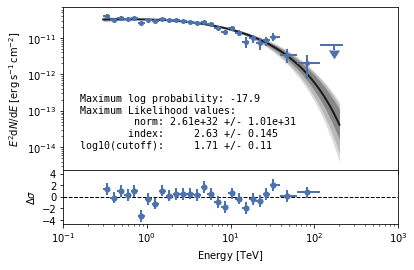

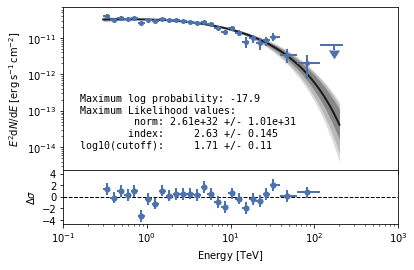

In [5]:
naima.plot_fit(sampler, modelidx=0, label=None, sed=True, last_step=False, 
               n_samples=100, confs=[3,2,1], ML_info=True, 
               figure=None, plotdata=True, plotresiduals=True, 
               e_unit=None, e_range=(300*u.GeV,200*u.TeV), e_npoints=200, threads=3, 
               xlabel=None, ylabel=None, ulim_opts={}, errorbar_opts={})

#Plot the fit results.
#Try confs=None, or try e_range=None

In [6]:
#output files

%ls RXJ1713_IC_minimal*

RXJ1713_IC_minimal_chain_cutoff.png  RXJ1713_IC_minimal_corner.png
RXJ1713_IC_minimal_chain.h5          RXJ1713_IC_minimal_model0.png
RXJ1713_IC_minimal_chain_index.png   RXJ1713_IC_minimal_results.ecsv
RXJ1713_IC_minimal_chain_norm.png


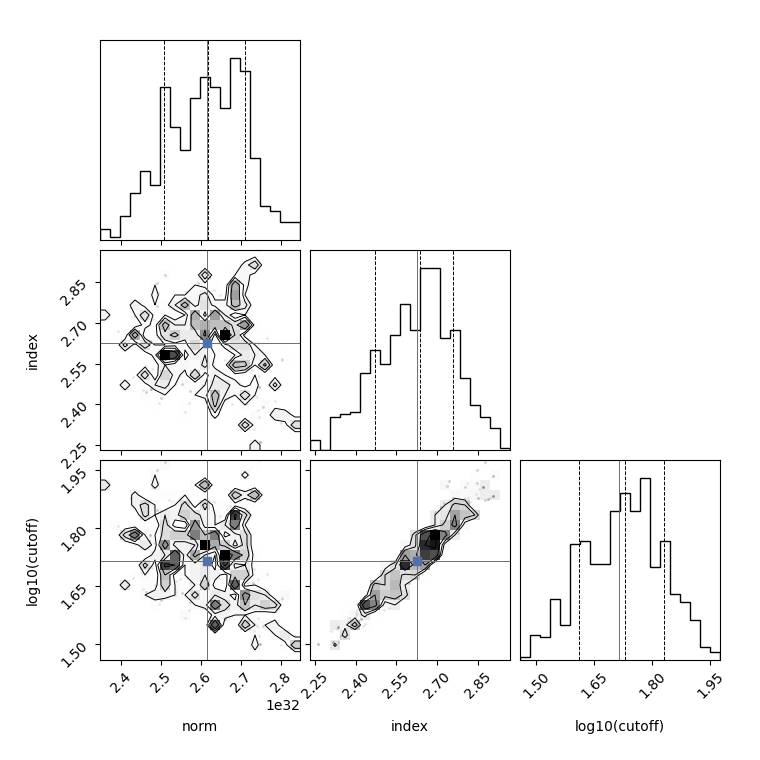

In [7]:
from IPython.display import Image, display 

#corner plot shows 1-D and 2-D projections of posterior probability.
#Useful to check correlations between parameters, see if the sampling was run
#with enough statistics etc.
display(Image("RXJ1713_IC_minimal_corner.png"))

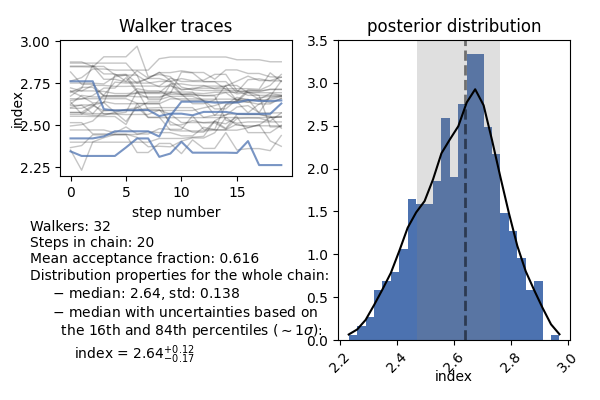

In [8]:
#Chain plots show the 1-D projection of the posterior distribution for a given parameter
#as well as the evolution of the parameter during the sampling.
display(Image("RXJ1713_IC_minimal_chain_index.png"))